# Number density and bias with real data

In [2]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

##### Calling Gold mask and calculating map area

In [13]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

##### DES + GOLD catalogs 

In [2]:
merged_des_basicCut = io.getDESY1A1catalogs(keyword = 'basicCut', gold=True)

merged_des_gold_basicCut02.fits
merged_des_gold_basicCut05.fits
merged_des_gold_basicCut07.fits
merged_des_gold_basicCut10.fits
merged_des_gold_basicCut12.fits
merged_des_gold_basicCut15.fits
merged_des_gold_basicCut00.fits
merged_des_gold_basicCut03.fits
merged_des_gold_basicCut06.fits
merged_des_gold_basicCut08.fits
merged_des_gold_basicCut11.fits
merged_des_gold_basicCut14.fits
merged_des_gold_basicCut16.fits
merged_des_gold_basicCut01.fits
merged_des_gold_basicCut04.fits
merged_des_gold_basicCut09.fits
merged_des_gold_basicCut13.fits
merged_des_gold_basicCut17.fits
merged_des_gold_basicCut18.fits
merged_des_gold_basicCut19.fits


In [142]:
merged_des_basicCut_s, _ = priorCut( merged_des_basicCut )
merged_des_basicCut = None

prior cut  14927271


In [8]:
# calling gold + des catalog
#merged_des_st82 = fitsio.read('result_cat/merged_des_st82_nocut.fits') # in stripe82
#merged_des_patch = fitsio.read('result_cat/merged_des_spt_nocut.fits') # spt 0<ra<100, -52<dec<-48
#merged_des_basicCut = fitsio.read('/n/des/lee.5922/data/gold_cat/merged_des_gold_basicCut.fits')
# prior Cut, limit survey depth
#from cmass_modules import Cuts

merged_des_st82 = merged_des_basicCut_s[merged_des_basicCut_s['DEC'] > -3]
merged_des_patch = merged_des_basicCut_s[merged_des_basicCut_s['DEC'] < -3]

merged_des_st82_s  = Cuts.doBasicCuts( merged_des_st82 )
merged_des_patch_s = Cuts.doBasicCuts( merged_des_patch )

merged_des_st82_s, _ = priorCut( merged_des_st82_s )
merged_des_patch_s, _ = priorCut( merged_des_patch_s )
#merged_des_patch_s = merged_des_patch_s[(merged_des_patch_s['RA'] < 90)]# & (merged_des_patch_s['RA'] > 10)]

1291427 946 69
do Basic Cut 1291427
13623832 9684 1313
do Basic Cut 13623832
prior cut  1291427
prior cut  13623832


In [16]:
####### delete below line later #########
#merged_des_st82_s21 = merged_des_st82_s[merged_des_st82_s['MAG_AUTO_I_corrected'] <= 21]
#merged_des_patch_s21 = merged_des_patch_s[merged_des_patch_s['MAG_AUTO_I_corrected'] <= 21]
####### delete below line later #########

####### delete below line later #########
merged_des_st82_s = merged_des_st82_s[merged_des_st82_s['MAG_AUTO_I_corrected'] <= 21]
merged_des_patch_s = merged_des_patch_s[merged_des_patch_s['MAG_AUTO_I_corrected'] <= 21]
####### delete below line later #########

figsave : figure/spatialtest_.png
1265.88758983 125.223800318


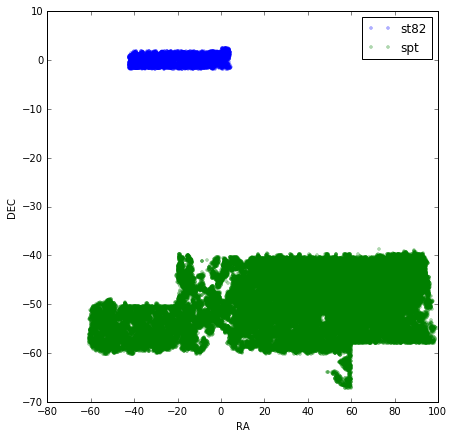

In [14]:
rows = np.random.choice(merged_des_st82_s.size, size = merged_des_st82_s.size/100)
rows2 = np.random.choice(merged_des_patch_s.size, size = merged_des_patch_s.size/100)
spatialcheck([merged_des_st82_s[rows], merged_des_patch_s[rows2]], label=['st82', 'spt'])
print SPTMaparea, ST82Maparea

Check spatial map

##### CMASS in des catalog 

In [18]:
# calling cmass

cmass = io.getSGCCMASSphotoObjcat()
cmass = Cuts.keepGoodRegion(cmass)
cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82_s['RA'], \
                                     merged_des_st82_s['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82_s.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82_s[cmass_mask], merged_des_st82_s[~cmass_mask]

Applying Healpix BOSS SGC footprint mask
Spatial Cut  10641


##### Assigning CMASS membership probability with XD algorithm 

In [152]:
# Divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.9,0.1], random_state=0)
des_train = merged_des_st82_s[trainInd]
des_test = merged_des_st82_s[testInd]

no_train, no_test = [0.1,0.9]
train_ind = np.random.choice( merged_des_st82_s.size, size = int(merged_des_st82_s.size * no_train))
train_mask = np.zeros(merged_des_st82_s.size, dtype = bool)
train_mask[train_ind] = 1
des_train = merged_des_st82_s[train_mask]
des_test = merged_des_st82_s[~train_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_train['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
cmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_test['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_test.size, dtype=bool)
cmass_mask[m2] = 1
cmass_test, _ = des_test[cmass_mask], des_test[~cmass_mask]

print cmass_train.size, cmass_test.size, des_train.size, des_test.size

768 7245 57699 548522


In [153]:
print \
clean_cmass_data_des.size * 1./merged_des_st82_s.size, \
cmass_train.size*1./des_train.size, \
cmass_test.size*1./des_test.size # test is always small..why?

0.013217951869 0.0133104559871 0.0132082213658


In [154]:
# Fitting
#pickleFileName = 'pickle/gold_st82_cut21_XD_no.pkl' #
pickleFileName = 'pickle/gold_st82_24_cut21_XD_no.pkl'
#rows = np.random.choice(nocmass_train.size, size=nocmass_train.size/10)                    
clf_no = XD_fitting( nocmass_train, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '_no', n_cl = 30 )
#pickleFileName =  'pickle/gold_st82_cut21_XD_cmass.pkl' #
pickleFileName = 'pickle/gold_st82_24_cut21_XD_cmass.pkl'
#pickleFileName = 'pickle/gold_st82_23_cut21_XD_cmass.pkl'
clf_cmass = XD_fitting( cmass_train, pickleFileName = pickleFileName, \
                  #init_params= 'pickle/gold_st82_20_XD_cmass.pkl',\
                       suffix = '_cmass', n_cl = 15 )

@pickle_results: computing results and saving to 'pickle/gold_st82_24_cut21_XD_no.pkl'
expected time: 17379.77 s,  process: 3.60 % 

OSError: [Errno 12] Cannot allocate memory

In [10]:
#cmass_fraction = cmass_train.size*1./des_train.size #0.015029276573 ratio of train
cmass_fraction = clean_cmass_data_des.size *1./merged_des_st82_s.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
des_test = assignCMASSProb( des_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
des_train = assignCMASSProb( des_train, clf_cmass, clf_no, cmass_fraction = cmass_fraction )

cmass_fraction 0.0152828558514
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [11]:
merged_des_st82_s = np.hstack([des_train, des_test])

In [1]:
probability_calibration( des = des_train, cmass_des = cmass_train, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_21_train' )
probability_calibration( des = des_test, cmass_des = cmass_test, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_21_test' )
probability_calibration( des = merged_des_st82_s, cmass_des = clean_cmass_data_des, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_21' )

NameError: name 'probability_calibration' is not defined

##### DMASS sampling

In [20]:
dmass_train, _ = resampleWithPth( des_train, pstart = 0, pmax = 1.0 )
print 100. * dmass_train.size/ cmass_train.size, '%'
dmass_test, _ = resampleWithPth( des_test, pstart = 0, pmax = 1.0 )
print 100. * dmass_test.size/ cmass_test.size, '%'
dmass, _ = resampleWithPth( merged_des_st82_s, pstart = 0, pmax = 1.0 )
print 100. * dmass.size/ clean_cmass_data_des.size, '%'


"""
GoldMask_st82_test = GoldMask_st82[GoldMask_st82['RA'] < 340]
GoldMask_st82_train = GoldMask_st82[GoldMask_st82['RA'] >= 340]
true = cmass_train.size *1./(GoldMask_st82_train.size * pixarea)
true_test = cmass_test.size *1./(GoldMask_st82_test.size * pixarea)
true_all = clean_cmass_data_des.size *1./ST82Maparea
print '\n',true,'N/deg^2', true_test,'N/deg^2', true_all,'N/deg^2'
print dmass_train.size *1./(GoldMask_st82_train.size * pixarea)/true_all
print dmass_test.size *1./(GoldMask_st82_test.size * pixarea)/true_all
print dmass.size *1./ST82Maparea/true_all
"""
print ''

106.218274112 %
102.740484429 %
103.194808436 %



In [56]:
# test spt region
des_patch_test = merged_des_patch_s[(merged_des_patch_s['RA'] >= 0) & (merged_des_patch_s['RA'] < 30)]
des_patch_test = des_patch_test[des_patch_test['MAG_AUTO_I_corrected'] <= 21]
des_patch_test = assignCMASSProb( des_patch_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
GoldMask_spt_test = GoldMask_spt[(GoldMask_spt['RA'] >= 0) & (GoldMask_spt['RA'] < 30)]
dmass_patch, _ = resampleWithPth( des_patch_test, pstart = 0, pmax = 1.0 )

true_all = clean_cmass_data_des.size *1./ST82Maparea
print dmass_patch.size *1./ (GoldMask_spt_test.size * pixarea) / true_all

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
0.831007177213


In [18]:
ra_divide = np.linspace(320, 360, 5)
ind = np.digitize(merged_des_st82_s['RA'], bins = ra_divide)
ind2 = np.digitize(clean_cmass_data_des['RA'], bins = ra_divide)

des_t = [None for i in np.arange(1,5)]
for i in np.arange(1, 5):
    ma = ind == i
    ma2 = ind2 == i
    f_c = np.sum(ma2) * 1./np.sum(ma)
    print i, f_c
    #des_t[i-1] = merged_des_st82_s[ma]
    des_t[i-1] = assignCMASSProb( merged_des_st82_s[ma], clf_cmass, clf_no, cmass_fraction = f_c )

des_t = np.hstack(des_t)

1 0.0149430811282
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
2 0.0144243337588
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
3 0.015660018126
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
4 0.0161521230189
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


save fig: com_pur_results/_probability_calibration.png
1.08359948958 %
save fig: com_pur_results/_probability_calibration.png
0.998159554398 %
save fig: com_pur_results/_probability_calibration.png
1.04957869756 %
save fig: com_pur_results/_probability_calibration.png
0.98793639864 %


(0.9, 1.1)

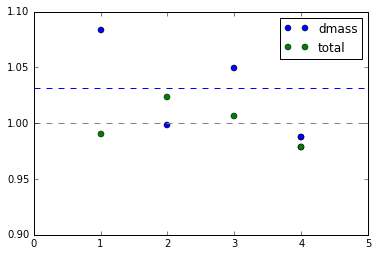

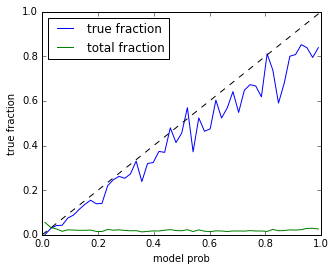

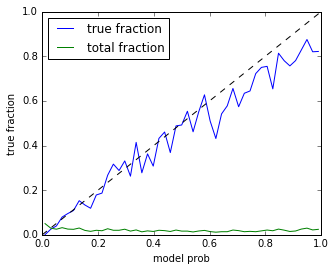

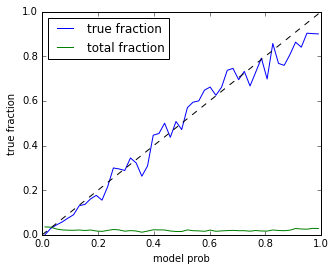

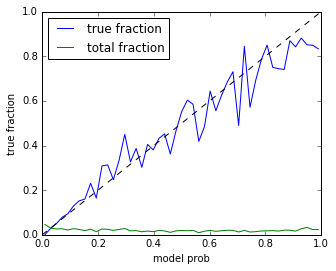

In [19]:
ra_divide = np.linspace(320, 360, 5)
ind3 = np.digitize(des_t['RA'], bins = ra_divide)
ind2 = np.digitize(clean_cmass_data_des['RA'], bins = ra_divide)
ind4 = np.digitize(GoldMask_st82['RA'], bins = ra_divide)
#n_dmass = 0
fig, ax = plt.subplots()

dmass_tot = 0
for i in np.arange(1,5):
    ma = ind3 == i
    ma2 = ind2 == i
    ma4 = ind4 == i
    probability_calibration( des = des_t[ma], cmass_des = clean_cmass_data_des[ma2], \
                        matchID= 'COADD_OBJECTS_ID', prefix = '' )
    dmass_t, _ = resampleWithPth( des_t[ma], pstart = 0, pmax = 1.0 )
    dmass_tot += dmass_t.size
    n_dmass = dmass_t.size *1./(np.sum(ma4) * pixarea)/true_all
    n_des = np.sum(ma) *1./(np.sum(ma4) * pixarea)/(des_t.size/ST82Maparea)
    print n_dmass, '%'
    ax.plot(i, n_dmass, 'bo')
    ax.plot(i, n_des, 'go')
    ax.set_xlim(0, 5)
ax.axhline(y=1.0, linestyle='--', color = 'grey')
ax.axhline(y = dmass_tot *1./clean_cmass_data_des.size, linestyle = '--', color = 'blue')
ax.plot(i, n_dmass, 'bo', label = 'dmass')
ax.plot(i, n_des, 'go', label = 'total')
ax.legend(loc='best')
ax.set_ylim(0.9, 1.1)

writing output plot to: figure/gold_st82_23_cut21_all_diagnostic_histograms_1d.png
writing output plot to: figure/gold_st82_23_cut21_dmass_diagnostic_histograms_1d.png


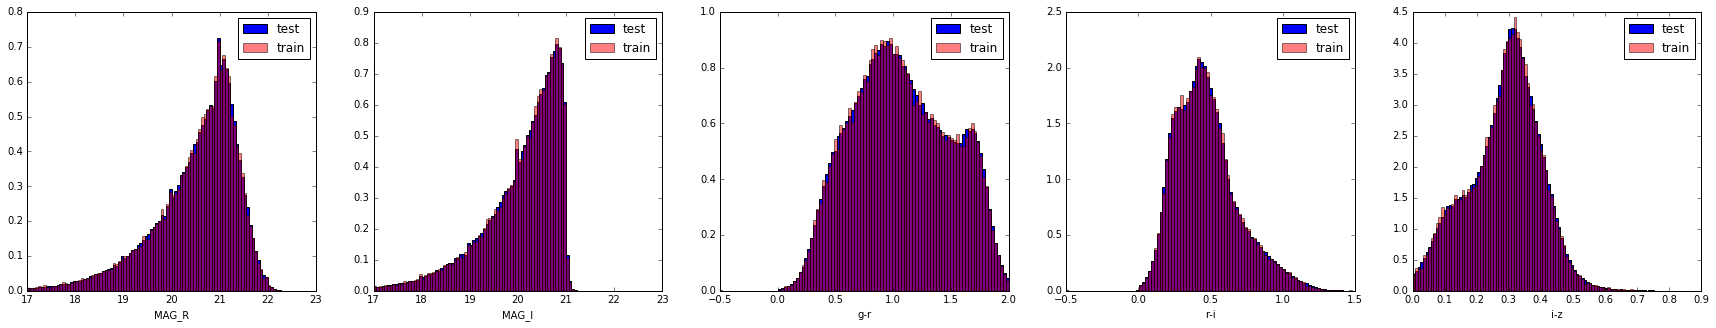

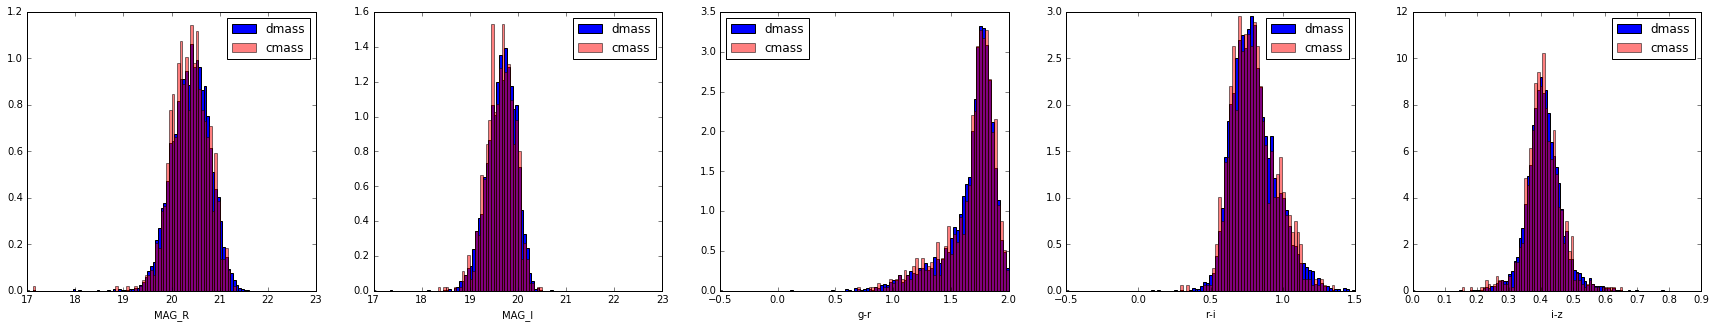

In [22]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(des_train)
X_test,_ = mixing_color(des_test)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='gold_st82_23_cut21_all_')
# Plotting dmass
X_cmass,_ = mixing_color(cmass_train)
X_dmass,_ = mixing_color(dmass)
doVisualization_1d( X_cmass, X_dmass,  labels = labels, ranges = ranges,\
                         name =['cmass','dmass' ], nbins=100, prefix='gold_st82_23_cut21_dmass_')

----

##### Error convolved distribution

In [47]:
cmass_model = clf_cmass.sample(cmass_train.size)
no_model = clf_no.sample(nocmass_train.size)

X_train, Xcov_train = mixing_color(des_train)
X_test,_ = mixing_color(des_test)

noisy_cmass_model = add_errors_multiprocessing(cmass_model, X_train[cmass_mask], Xcov_train[cmass_mask])
nosiy_no_model = add_errors_multiprocessing(no_model, X_train[~cmass_mask], Xcov_train[~cmass_mask])

add noise to sample 100 %
add noise to sample 100 %


writing output plot to: figure/model_cmass_diagnostic_histograms_1d.png
writing output plot to: figure/model_no_diagnostic_histograms_1d.png


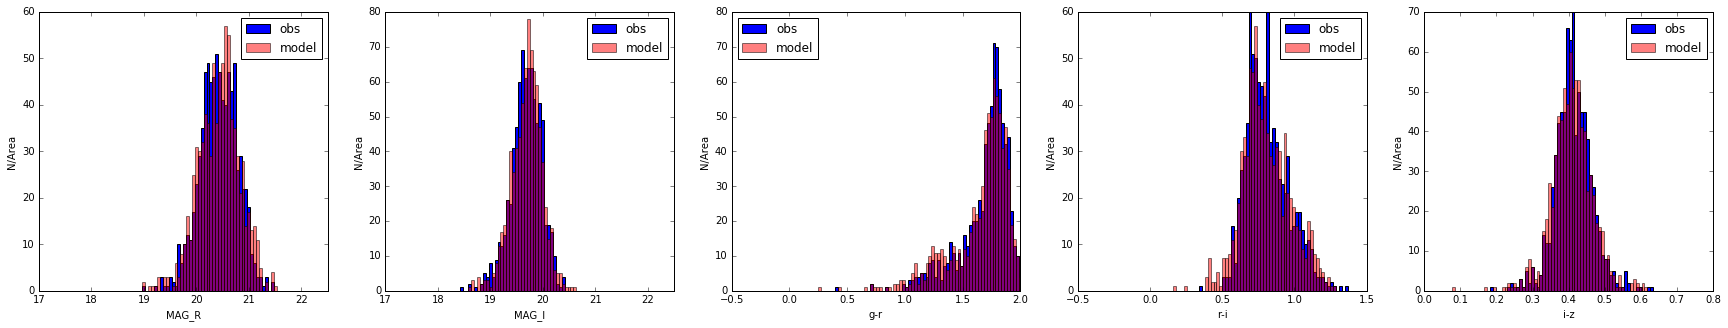

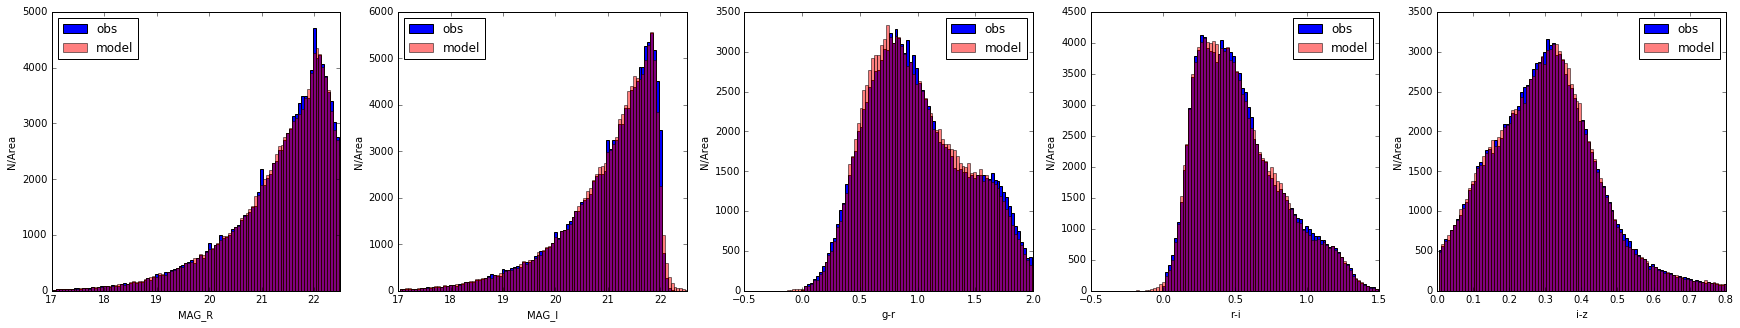

In [48]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-.5,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( noisy_cmass_model, X_train[cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='model_cmass_')
doVisualization_1d_NperA( nosiy_no_model, X_train[~cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='model_no_')

##### underlying distribution

In [195]:
# Fitting
pickleFileName = 'pickle/gold_st82_21_XD_all.pkl'
rows = np.random.choice(des_train.size, size=int(des_train.size /10.)) 
clf_all = XD_fitting( des_train[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/gold_st82_21_XD_no.pkl', suffix = '_all1', n_cl = 25 )
pickleFileName = 'pickle/gold_st82_21_XD_all_patch.pkl'
rows = np.random.choice(merged_des_patch_s.size, size=int(merged_des_patch_s.size /50.))                    
clf_all2 = XD_fitting( merged_des_patch_s[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/gold_st82_21_XD_no.pkl', suffix = '_all2', n_cl = 25 )

@pickle_results: using precomputed results from 'pickle/gold_st82_21_XD_all.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_21_XD_all_patch.pkl'


In [192]:
#rm pickle/gold_st82_21_XD_all.pkl pickle/gold_st82_21_XD_all_patch.pkl

writing output plot to: figure/model_diagnostic_histograms_1d.png


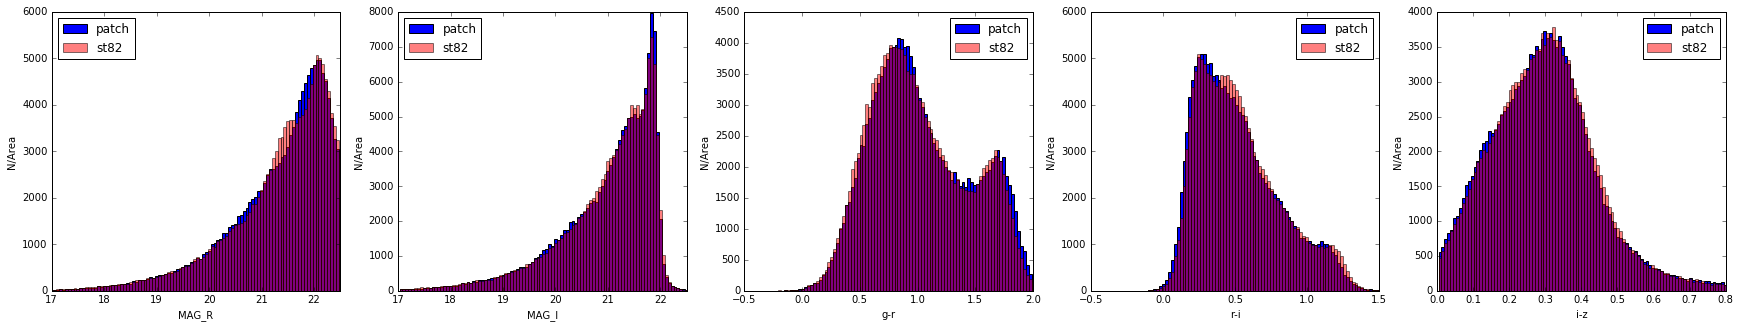

In [196]:
clean_all = clf_all.sample(des_train.size)
clean_all2 = clf_all2.sample(des_train.size)

labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-.5,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( clean_all, clean_all2, area=[1,1], labels = labels, ranges = ranges,\
                         name =['st82','patch' ], nbins=100, prefix='model_')

----

## Density vs maglimit

In [12]:
# apply basic Cuts to maglim map
path = '/n/des/lee.5922/data/balrog_cat/'
goodmask = path+'y1a1_gold_1.0.2_wide_footprint_4096.fit'
badmask = path+'y1a1_gold_1.0.2_wide_badmask_4096.fit'
fraction = hp.read_map(path+'Y1A1_WIDE_frac_combined_griz_o.4096_t.32768_EQU.fits')

# Note that the masks here in in equatorial, ring format.
gdmask = hp.read_map(goodmask)
bdmask = hp.read_map(badmask)

ind_good_ring = np.where(( gdmask >= 1)
                         & ((bdmask.astype('int64') & (64+32+8)) == 0)
                         & (fraction > 0.8)
                         )

goldmask = np.zeros(gdmask.size, dtype=bool)
goldmask[ind_good_ring] = 1

path = '/n/des/lee.5922/data/systematic_maps/'
maglim_i = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_i_10sigma.fits')
maglim_i[~goldmask] = hp.UNSEEN

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [3]:
# calling data w/o cuts
#des_gold_st82_list = []
des_gold_spt1_list = []
#des_gold_spt2_list = []
for i in range(3):
    des_gold = io.getDESY1A1catalogs(keyword = 'merged_'+str(i), gold=True)
    #des_gold_st82 = Cuts.SpatialCuts(des_gold, ra=320, ra2=360, dec = -2, dec2 = 2)
    des_gold_spt1 = Cuts.SpatialCuts(des_gold, ra=0, ra2=100, dec = -48, dec2 = -44)
    #des_gold_spt2 = Cuts.SpatialCuts(des_gold, ra=50, ra2=100, dec = -52, dec2 = -48)
    #des_gold_st82_list.append(des_gold_st82)
    des_gold_spt1_list.append(des_gold_spt1)
    #des_gold_spt2_list.append(des_gold_spt2)
    des_gold = None
"""
des_gold_st82_list = np.hstack(des_gold_st82_list)
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO', 'MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold_st82_list = getCorrectedMag( des_gold_st82_list, mags = mags, reddening = None )
fitsio.write('result_cat/merged_des_st82_nocut.fits', des_gold_st82_list, clobber = True)
"""
des_gold_spt1_list = np.hstack(des_gold_spt1_list)
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO', 'MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold_spt1_list = getCorrectedMag( des_gold_spt1_list, mags = mags, reddening = None )
fitsio.write('result_cat/merged_des_spt_nocut.fits', des_gold_spt1_list, clobber = True)

Y1A1_GOLD_merged_01.fits
Y1A1_GOLD_merged_02.fits
Y1A1_GOLD_merged_03.fits
Y1A1_GOLD_merged_04.fits
Y1A1_GOLD_merged_05.fits
Y1A1_GOLD_merged_06.fits
Y1A1_GOLD_merged_07.fits
Y1A1_GOLD_merged_08.fits
Y1A1_GOLD_merged_09.fits
Spatial Cut  4970916
Spatial Cut  11313779
Y1A1_GOLD_merged_10.fits
Y1A1_GOLD_merged_11.fits
Y1A1_GOLD_merged_12.fits
Y1A1_GOLD_merged_13.fits
Y1A1_GOLD_merged_14.fits
Y1A1_GOLD_merged_15.fits
Y1A1_GOLD_merged_16.fits
Y1A1_GOLD_merged_17.fits
Y1A1_GOLD_merged_18.fits
Y1A1_GOLD_merged_19.fits
Spatial Cut  2665556
Spatial Cut  2269240
Y1A1_GOLD_merged_20.fits
Spatial Cut  216904
Spatial Cut  311760


In [160]:
def CalculateOverdensity(des, maglim_i, nside = 512):
    # maglim should be masked in advance
    
    maglim_i_256 = hp.ud_grade(maglim_i, nside_out = nside, pess=True)
    bdmask = maglim_i_256 > 0
    mapInd = np.arange(maglim_i_256.size)[bdmask] 
    buzInd = hpRaDecToHEALPixel( des['RA'], des['DEC'],nside=nside)
    
    
    
    # combine array
    maglim_i_com = np.zeros((maglim_i_256[bdmask].size,), \
                            dtype=[('pix', 'int'),('sig', 'float')])                        
    maglim_i_com['pix'] = mapInd
    maglim_i_com['sig'] = maglim_i_256[bdmask]
    
    
    MM = np.in1d(mapInd, buzInd)
    maglim_i_com = maglim_i_com[MM]
    
    r, d = hpHEALPixelToRaDec(maglim_i_com['pix'], nside = nside)
    fig, ax = plt.subplots()
    ax.plot(r, d, '.')
    
    
    N = []
    for i in range(maglim_i_com.size):
        n = np.sum(buzInd == maglim_i_com['pix'][i])
        N.append(n)
    N = np.array(N)
    
    Apix256 = hp.nside2pixarea( nside, degrees = True)
    n256 = (N/Apix256) #[effectivemask]
    #mapIndinbuz_mask = np.in1d(mapInd, buzInd)
    #Atot = np.sum(bdmask) * Apix256
    #ntot = des.size/Atot
    ntot = np.mean(n256)
    overdensity = (n256/ntot)
    
    bin_mag, s = np.linspace(21.8, 23, 20, retstep=True)
    #bin_mag = #bin_mag + s/2.
    mag_ind = np.digitize(maglim_i_com['sig'], bins = bin_mag)
    avg_overdensity = []
    error_over = []
    for i in range(bin_mag.size):
        ma = mag_ind == i
        avg = np.mean(overdensity[ma])
        avg_overdensity.append(avg)
        Nt = np.sum(N[ma])
        #print np.std(overdensity[ma])
        err = np.std(overdensity[ma]) /np.sqrt(np.sum(ma))
        error_over.append(err)
        
    return np.array(bin_mag), np.array(avg_overdensity), np.array(error_over)

In [66]:
# masking maglim map within stripe82 region
mapInd = np.arange(maglim_i.size)
r, d = hpHEALPixelToRaDec(mapInd, nside = 4096)
mask = (r > 320)&(r < 360) & (d >-2)&(d<2)
maglim_i_st82 = maglim_i.copy()
maglim_i_st82[~mask] = hp.UNSEEN

# masking maglim map within spt region
mask_spt = (r > 0)&(r < 100) & (d >-52)&(d<-48)
maglim_i_spt = maglim_i.copy()
maglim_i_spt[~mask_spt] = hp.UNSEEN

nan
0.0614206832197
0.103998208837
0.114463079785
0.127525798663
0.118901595
0.117321217773
0.133722649768
0.129317375319
0.131427133839
0.12127907391
0.131729675726
0.131255439806
0.136870884207
0.135309326023
0.125617853857
0.158645248827
0.128205488922
0.0927554997303
0.0822501367118


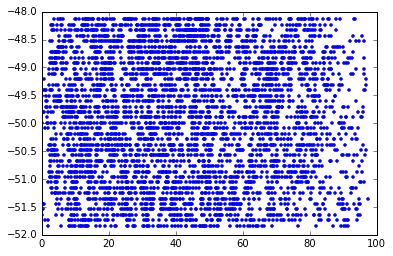

In [158]:
bin_mag, avg_overdensity, error_over = CalculateOverdensity(merged_des_st82, maglim_i_st82, nside = 512)
bin_mag2, avg_overdensity2, error_over2 = CalculateOverdensity(merged_des_patch, maglim_i_spt, nside = 512)

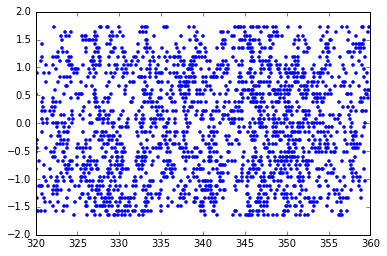

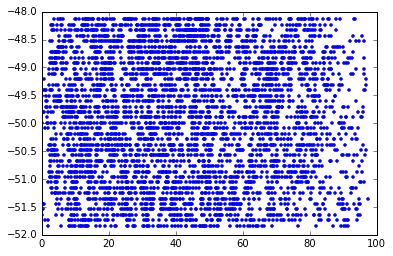

In [165]:
merged_des_st82_2 = merged_des_st82[merged_des_st82['MAG_AUTO_I_corrected']<= 21]
merged_des_patch_2 = merged_des_patch[merged_des_patch['MAG_AUTO_I_corrected']<= 21]
bin_mag3, avg_overdensity3, error_over3 = CalculateOverdensity(merged_des_st82_2, maglim_i_st82, nside = 512)
bin_mag4, avg_overdensity4, error_over4 = CalculateOverdensity(merged_des_patch_2, maglim_i_spt, nside = 512)

In [168]:
def chisquare_test(avg_overdensity, error_over):

    avg_overdensity = np.array(avg_overdensity)
    error_over = np.array(error_over)
    mask = np.ma.masked_invalid(avg_overdensity)
    #mask2 = np.ma.masked_invalid(error_over)
    m = ((~mask.mask) & (error_over != 0))
    #m2 = ~mask2.mask
    galaxy_density = avg_overdensity[m]
    err = error_over[m]
    bin = bin_mag[m]
    chisquare = np.sum((galaxy_density - 1.0)**2/err**2 )
    return chisquare/np.sum(m)

In [169]:
chi1 = chisquare_test(avg_overdensity, error_over)
chi2 = chisquare_test(avg_overdensity2, error_over2)

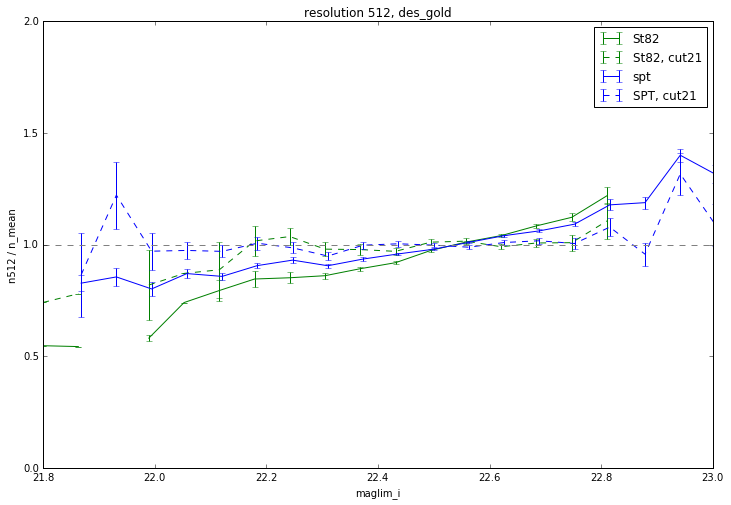

In [166]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
#ax.plot(maglim_i_256[bdmask][zeromask], overdensity, '.')
#ax.plot(bin_mag, avg_overdensity, '.')
ax.errorbar(bin_mag, avg_overdensity, yerr = error_over, color = 'green', label = 'St82')
ax.errorbar(bin_mag3, avg_overdensity3, yerr = error_over3, color = 'green', linestyle = '--', label = 'St82, cut21')
ax.errorbar(bin_mag2 + 0.005, avg_overdensity2, yerr = error_over2, color = 'blue', label = 'spt')
ax.errorbar(bin_mag4 + 0.005, avg_overdensity4, yerr = error_over4, color = 'blue', linestyle='--',label='SPT, cut21')
ax.axhline(y=1, color='grey', linestyle='--')
ax.set_xlabel('maglim_i')
ax.set_ylabel('n512 / n_mean')
ax.set_title('resolution 512, des_gold')
ax.set_ylim(0,2)
ax.set_xlim(21.8, 23)
ax.legend(loc='best')

## Density comparison in SPT and stripe82

In [35]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    mu, sigma = np.mean(data['DESDM_ZP']), np.std(data['DESDM_ZP'])
    z_R = np.random.normal(mu, sigma, size)
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float'), ('DESDM_ZP', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
    data_R['DESDM_ZP'] = z_R
                              
    return data_R

In [85]:
# dmass from spt
merged_des_patch_s1 = merged_des_patch_s[merged_des_patch_s['RA'] < 30]
merged_des_patch_s2 = merged_des_patch_s[(merged_des_patch_s['RA'] >= 30)&(merged_des_patch_s['RA'] < 60)]
merged_des_patch_s3 = merged_des_patch_s[merged_des_patch_s['RA'] >= 60]
merged_des_patch_s1 = assignCMASSProb(merged_des_patch_s1 , clf_cmass, clf_no, cmass_fraction = cmass_fraction )
merged_des_patch_s2 = assignCMASSProb(merged_des_patch_s2 , clf_cmass, clf_no, cmass_fraction = cmass_fraction )
merged_des_patch_s3 = assignCMASSProb(merged_des_patch_s3 , clf_cmass, clf_no, cmass_fraction = cmass_fraction )
merged_des_patch_s = np.hstack([merged_des_patch_s1, merged_des_patch_s2, merged_des_patch_s3 ])

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [100]:
dmass_spt, _ = resampleWithPth( merged_des_patch_s, pstart = 0, pmax = 1.0 )

In [101]:
rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
rand_train = Cuts.keepGoodRegion(rand_train)
#rand_test = uniform_random_on_sphere(dmass, size = 100 * dmass.size)
#rand_test = Cuts.keepGoodRegion(rand_test)
rand = uniform_random_on_sphere(dmass_spt, size = 100 * dmass_spt.size)
rand = Cuts.keepGoodRegion(rand)

In [102]:
print dmass_spt.size *1./rand.size /(clean_cmass_data_des.size *1./ rand_train.size)
print (dmass.size *1./ rand_train.size)/(clean_cmass_data_des.size *1./ rand_train.size)

0.932571683077
1.03194808436


In [286]:
# fitting dmass cut 21
merged_des_st82_s21 = merged_des_st82_s[merged_des_st82_s['MAG_AUTO_I_corrected']<= 21]
merged_des_patch_s21 = merged_des_patch_s[merged_des_patch_s['MAG_AUTO_I_corrected']<= 21]


m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82_s21['RA'], \
                                     merged_des_st82_s21['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82_s21.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des21, nocmass21 = merged_des_st82_s21[cmass_mask], merged_des_st82_s21[~cmass_mask]

"""

# Divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_des_st82_s21, merged_des_st82_s21, [0.2,0.8], random_state=0)
des_train21 = merged_des_st82_s21[trainInd]
des_test21 = merged_des_st82_s21[testInd]
#des_train = merged_des_st82_s[merged_des_st82_s['RA'] < 330]
#des_test = merged_des_st82_s[merged_des_st82_s['RA'] >= 330]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des21['COADD_OBJECTS_ID'], des_train21['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_train21.size, dtype=bool)
cmass_mask[m2] = 1
cmass_train, nocmass_train = des_train21[cmass_mask], des_train21[~cmass_mask]
print cmass_train.size, des_train21.size


# Fitting
pickleFileName = 'pickle/gold_st82_cut21_XD_no.pkl'
rows = np.random.choice(nocmass_train.size, size=nocmass_train.size/10)                    
clf_no21 = XD_fitting( nocmass_train[rows], pickleFileName = pickleFileName, \
                  init_params=None, suffix = '_no', n_cl = 25 )
pickleFileName = 'pickle/gold_st82_cut21_XD_cmass.pkl'
clf_cmass21 = XD_fitting( cmass_train, pickleFileName = pickleFileName, \
                  #init_params= 'pickle/gold_st82_20_XD_cmass.pkl',\
                       suffix = '_cmass', n_cl = 10 )

cmass_fraction = 0.01# cmass_train.size * 1./des_train.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
des_test21 = assignCMASSProb( des_test21, clf_cmass21, clf_no21, cmass_fraction = cmass_fraction )
des_train21 = assignCMASSProb( des_train21, clf_cmass21, clf_no21, cmass_fraction = cmass_fraction )

probability_calibration( des = des_test21, cmass_des = clean_cmass_data_des21, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_cut21' )


#merged_des_st82_s.dtype.names
dmass_st82_21, _ = resampleWithPth(merged_des_st82_s21, pstart = 0, pmax = 1.0 )
"""

"\n\n# Divide sample into train and test\n(trainInd, testInd), _ = split_samples(merged_des_st82_s21, merged_des_st82_s21, [0.2,0.8], random_state=0)\ndes_train21 = merged_des_st82_s21[trainInd]\ndes_test21 = merged_des_st82_s21[testInd]\n#des_train = merged_des_st82_s[merged_des_st82_s['RA'] < 330]\n#des_test = merged_des_st82_s[merged_des_st82_s['RA'] >= 330]\n\nm1, m2 = esutil.numpy_util.match(clean_cmass_data_des21['COADD_OBJECTS_ID'], des_train21['COADD_OBJECTS_ID'])\ncmass_mask = np.zeros(des_train21.size, dtype=bool)\ncmass_mask[m2] = 1\ncmass_train, nocmass_train = des_train21[cmass_mask], des_train21[~cmass_mask]\nprint cmass_train.size, des_train21.size\n\n\n# Fitting\npickleFileName = 'pickle/gold_st82_cut21_XD_no.pkl'\nrows = np.random.choice(nocmass_train.size, size=nocmass_train.size/10)                    \nclf_no21 = XD_fitting( nocmass_train[rows], pickleFileName = pickleFileName,                   init_params=None, suffix = '_no', n_cl = 25 )\npickleFileName = 'pickle

##### stop here 

In [57]:
#cmass_fraction = 0.01
#merged_des_patch_s21 = assignCMASSProb(merged_des_patch_s21 , clf_cmass21, clf_no21, cmass_fraction = cmass_fraction )
#dmass_spt21, _ = resampleWithPth( merged_des_patch_s21, pstart = 0, pmax = 1.0 )
#print dmass_spt21.size, dmass_st82_21.size

In [12]:
#def limiting21(des):
#path = '/n/des/lee.5922/data/systematic_maps/'
#maglim_i = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_i_10sigma.fits')
#ind_good_ring = np.where( maglim_i > 21 )

In [208]:
# divide spt regions into 10
#HPind = hpRaDecToHEALPixel(merged_des_patch_s['RA'], merged_des_patch_s['DEC'], nside=4096)
#maglimmask = np.in1d(np.arange(merged_des_patch_s.size), np.where( maglim_i > 22 ))
#merged_des_patch_s22 = merged_des_patch_s[maglimmask]

#maglimmask = np.in1d(np.arange(merged_des_patch_s.size), np.where( maglim_i > 21 ))
#merged_des_patch_s21 = merged_des_patch_s[maglimmask]

#merged_des_st82_s21 = merged_des_st82_s[merged_des_st82_s['MAG_AUTO_I_corrected'] < 21.]
#merged_des_patch_s21 = merged_des_patch_s[merged_des_patch_s['MAG_AUTO_I_corrected'] < 21.]

(-60, -40)

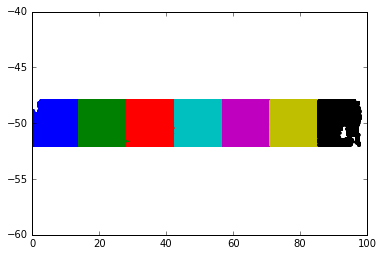

In [90]:
rabin = np.linspace(0, 100, 8)
N_gal,_ = np.histogram(merged_des_patch_s['RA'], bins = rabin)
N_map, _ = np.histogram(GoldMask_spt['RA'], bins = rabin)
A_map = N_map * pixarea

ind_map = np.digitize(GoldMask_spt['RA'], bins = rabin)
fig, ax = plt.subplots()
for i in range(1, rabin.size):
    ma = ind_map == i
    ax.plot(GoldMask_spt['RA'][ma], GoldMask_spt['DEC'][ma], '.') 

ax.set_ylim(-60, -40)

In [91]:
def CalculateNumDensity(cat, cleanMap):
    N_map = cleanMap.size
    pixarea = hp.nside2pixarea( 4096, degrees = True)
    A_map = N_map * pixarea
    num_density = cat.size * 1./A_map 
    return num_density

In [92]:
def CalculateNumDensity2(cat, random):
    num_density = cat.size * 1./random.size
    return num_density

In [93]:
# add jack knife error
def jkerror( catalog, cleanMap, njack = 10 ):
    import os

    # jk error
    jkfile = './jkregion.txt'
    jk.GenerateJKRegions( catalog['RA'], catalog['DEC'], njack, jkfile)
    jktest = jk.SphericalJK( target = CalculateNumDensity, jkargs=[catalog, cleanMap], \
                            jkargsby=[['RA', 'DEC'],['RA', 'DEC']], \
                            regions = jkfile)
    jktest.DoJK( regions = jkfile )
    jkresults = jktest.GetResults(jk=True, full = True)

    full_j = jkresults['full']   
    it = jkresults['it']
    it_j = jkresults['jk']
    
    norm = (njack-1)*1./njack
    #cov = np.std(it_j - full_j)**2 * norm
    cov = np.sum((it_j - it_j.mean())**2) * norm
    
    os.remove(jkfile)
    return np.mean(it_j), np.sqrt(cov)

In [94]:
rabin = np.linspace(0, 100, 8)
ind_map = np.digitize(merged_des_patch_s['RA'], bins = rabin)
ind_clean_map = np.digitize(GoldMask_spt['RA'], bins = rabin)

n_err = []
n_density = []

for i in range(1,rabin.size):
    ma = ind_map == i
    ma3 = ind_clean_map == i
    n, e = jkerror( merged_des_patch_s[ma], GoldMask_spt[ma3], njack = 20)    
    n_err.append(e)
    n_density.append(n)

n_err = np.array(n_err)
n_density = np.array(n_density)

X (696, 2)  centers (20, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [35 45 43 31 21 40 28 29 43 34 45 34 29 34 27 36 19 46 55 22]
X (121258, 2)  centers (20, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [5919 6229 4954 5310 5597 6854 5978 7366 5755 6247 6951 5270 4875 6593 4438
 7455 4903 8364 5448 6752]
X (773, 2)  centers (20, 2)  tol=1e-05  maxiter=200
17 iterations  cluster sizes: [69 38 41 52 31 40 29 34 36 32 41 27 41 25 29 45 25 49 55 34]
X (149749, 2)  centers (20, 2)  tol=1e-05  maxiter=200
45 iterations  cluster sizes: [10687  8446  6225  7701  7058  7761  6982  6993  6661  6887  7427  7788
  7474  5295  7956  8007  7107  7825  7857  7612]
X (822, 2)  centers (20, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [58 41 38 36 25 38 37 36 27 66 44 28 37 47 52 43 33 59 34 43]
X (169106, 2)  centers (20, 2)  tol=1e-05  maxiter=200
55 iterations  cluster sizes: [9336 8749 6994 9061 8184 8266 8131 8647 9013 8106 8055 6698 8401 8904 8979
 7980 8471 

In [95]:
ind_dmass = np.digitize(dmass_spt['RA'], bins = rabin)
#ind_dmass21 = np.digitize(dmass_spt21['RA'], bins = rabin)
ind_clean_map = np.digitize(GoldMask_spt['RA'], bins = rabin)

n_err_dmass = []
n_density_dmass = []

for i in range(1,rabin.size):
    ma = ind_dmass == i
    #ma2 = ind_dmass21 == i
    ma3 = ind_clean_map == i

    n, e = jkerror( dmass_spt[ma], GoldMask_spt[ma3], njack = 20)   
    n_err_dmass.append(e)
    n_density_dmass.append(n)
    
n_err_dmass = np.array(n_err_dmass)
n_density_dmass = np.array(n_density_dmass)

X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [10 10 12 13  8 10  2  4  8  8  9 10  7 11 10  9 11 20 20  8]
X (1470, 2)  centers (20, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 76  82 104 117  57  67  38  73  64  69  72  65  42  55  87  71  76 101
  93  61]
X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
10 iterations  cluster sizes: [12 15 12 10  8  9  7 11  5 18 12 14 18  3  3  7  9 11  4 12]
X (1865, 2)  centers (20, 2)  tol=1e-05  maxiter=200
29 iterations  cluster sizes: [ 86 108  97  92  80  66  82  97  77 126  82  87 144  78 112  83  78 119
  81  90]
X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
10 iterations  cluster sizes: [ 9  3  6 14 13 10 10 12  7  4 13  3 15 16 12 13  9  6  6 19]
X (2493, 2)  centers (20, 2)  tol=1e-05  maxiter=200
27 iterations  cluster sizes: [ 99 124 142 121 126 142 147 120 128 143 120 114 126 108 100 107 120 141
 107 158]
X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
10 iterations  clu

In [96]:
density_dmass, error_dmass = jkerror( dmass_spt, GoldMask_spt, njack = 20) 
density_dmass_st82, error_dmass_st82 = jkerror( dmass, GoldMask_st82, njack = 20) 
density_dmass_true, error_dmass_true = jkerror( clean_cmass_data_des, GoldMask_st82, njack = 20) 

X (238, 2)  centers (20, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 5  5  8 23 24 15 10 11 12 20 12  9 11 14 15  6  7  7  8 16]
X (14237, 2)  centers (20, 2)  tol=1e-05  maxiter=200
28 iterations  cluster sizes: [ 534  330  692  797  856  948  752  562  790 1088 1082  408  846  935  751
  698  590  345  753  480]
X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
8 iterations  cluster sizes: [11  6 13 19 11  8  8 10  5  9  9  9 19  4 11 10  4 12 11 11]
X (8269, 2)  centers (20, 2)  tol=1e-05  maxiter=200
28 iterations  cluster sizes: [376 408 475 521 512 320 296 296 431 399 356 292 502 193 486 476 252 551
 378 749]
X (200, 2)  centers (20, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [14  7  6  6 17  4  8 17  7 13 12 18 12  7 10 13  7  5 11  6]
X (8013, 2)  centers (20, 2)  tol=1e-05  maxiter=200
30 iterations  cluster sizes: [295 265 224 380 340 294 454 500 331 466 318 528 573 428 361 705 300 263
 401 587]


In [97]:
n_density_mean = CalculateNumDensity(merged_des_patch_s, GoldMask_spt)
#n_density_mean21 = CalculateNumDensity(merged_des_patch_s21, GoldMask_spt)

#n_density_true = CalculateNumDensity(des_train, GoldMask_st82_train)
n_density_true = CalculateNumDensity(merged_des_st82_s, GoldMask_st82)
#n_density_true21 = CalculateNumDensity(des_train[des_train['MAG_AUTO_I_corrected']< 21], GoldMask_st82_train)

n_density_dmass_st82_mean = CalculateNumDensity(dmass, GoldMask_st82)
n_density_dmass_mean = CalculateNumDensity(dmass_spt, GoldMask_spt)
#n_density_dmass_mean21 = CalculateNumDensity(dmass_spt21, GoldMask_spt)

n_density_dmass_true = CalculateNumDensity(clean_cmass_data_des, GoldMask_st82)
#n_density_dmass_true21 = CalculateNumDensity(cmass_train[cmass_train['MAG_AUTO_I_corrected']< 21], GoldMask_st82_train)

print n_density_dmass_true, n_density_dmass_mean, n_density_dmass_st82_mean
print \
n_density_mean / n_density_true, \
n_density_dmass_mean / n_density_dmass_true, \
n_density_dmass_st82_mean/ n_density_dmass_true

73.7098417172 69.2382086273 76.0647299588
1.00631885973 0.939334653477 1.03194808436


In [70]:
# poisson
areafactor =  np.sqrt(ST82Maparea/SPTMaparea)
sigma_f_true = np.sqrt(clean_cmass_data_des.size) *1./ST82Maparea * 1./n_density_dmass_true *areafactor
sigma_f_dmass_st82 = np.sqrt(dmass.size) *1./ST82Maparea * 1./n_density_dmass_true *areafactor
sigma_f_dmass = np.sqrt(dmass_spt.size) *1./SPTMaparea * 1./n_density_dmass_true
print sigma_f_true, sigma_f_dmass_st82, sigma_f_dmass

print error_dmass/n_density_dmass_true, error_dmass_st82/n_density_dmass_true, error_dmass_true/n_density_dmass_true

0.00830743542378 0.00843909544368 0.00805538432535
0.0261937320519 0.0289082754469 0.023576699596


In [71]:
print n_density_mean, n_density_true

4883.85010272 4823.04108827


(1, 1.0319239666111697) (1.0319239666111697, 0.028908275446908601) (0.94025225182448535, 0.026193732051896901)


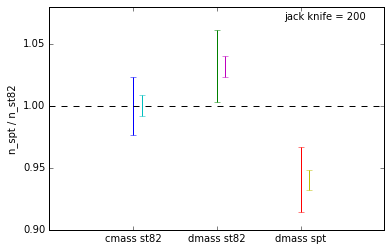

In [72]:
fig, ax = plt.subplots()
#ax.errorbar(1, 1, yerr = error_true/n_density_true, fmt='o', label='st82')
#ax.errorbar(2, density/density_true, yerr = error/n_density_true, fmt='o', label='spt')
ax.errorbar(3, 1, yerr = error_dmass_true/n_density_dmass_true, label='cmass st82')
ax.errorbar(4, density_dmass_st82/n_density_dmass_true, yerr = error_dmass_st82/n_density_dmass_true,label='dmass st82')
ax.errorbar(5, density_dmass/n_density_dmass_true,yerr = error_dmass/n_density_dmass_true, label='dmass spt')

ax.errorbar(3+0.1, 1, yerr = sigma_f_true, label='cmass st82, poisson')
ax.errorbar(4+0.1, density_dmass_st82/n_density_dmass_true, yerr = sigma_f_dmass_st82,label='dmass st82, poisson')
ax.errorbar(5+0.1, density_dmass/n_density_dmass_true,yerr = sigma_f_dmass, label='dmass spt, poisson')

#ax.errorbar(5, density_dmass21/density_dmass_true21, yerr = error_dmass21/density_dmass_true21, label='dmass spt 21')
ax.axhline(y = 1, color = 'black', linestyle='--')
ax.set_xlim(2, 6)
ax.set_ylabel('n_spt / n_st82')
ax.get_xaxis().set_ticks([3,4,5])
ax.get_xaxis().set_ticklabels(['cmass st82','dmass st82', 'dmass spt'])
#ax.legend(loc=None)
ax.text(4.8, 1.07, 'jack knife = 200')
fig.savefig('figure/total_density_comparison.png')


print (1, density_dmass_st82/n_density_dmass_true), (density_dmass_st82/n_density_dmass_true, error_dmass_st82/n_density_dmass_true), \
(density_dmass/n_density_dmass_true,error_dmass/n_density_dmass_true )

In [536]:
DAT = np.column_stack((n_density/n_density_true, n_err/n_density_true, n_density_dmass/n_density_dmass_true, n_err_dmass/n_density_dmass_true))
np.savetxt('data_txt/num_density_comparison_nocut.txt', DAT, header = 'n_spt/n_st82, spt_error, n_dmass_spt/n_cmass, dmass_error')

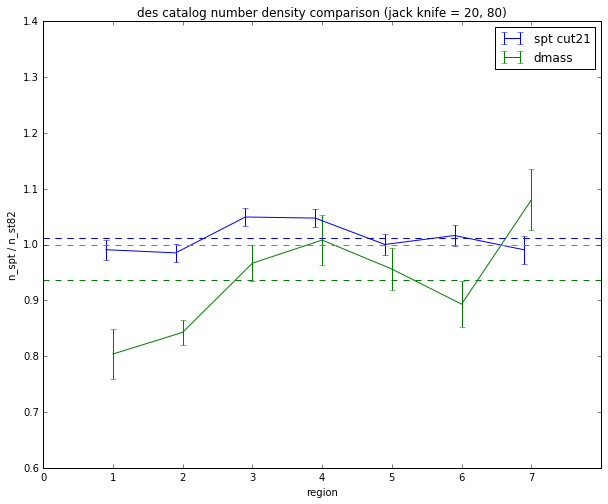

In [74]:

DAT = np.loadtxt('data_txt/num_density_comparison.txt')
n_density_21, n_err21, n_density_dmass_21, n_err_dmass21 = [DAT[:,i] for i in range(4)]

fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.errorbar(np.arange(1, rabin.size)-0.1, n_density/n_density_true, yerr = n_err/n_density_true, color = 'blue', label='spt cut21')
#ax.errorbar(np.arange(1, rabin.size), n_density_21, yerr = n_err21, color = 'red', label='spt cut 21')
ax.errorbar(np.arange(1, rabin.size), n_density_dmass/n_density_dmass_true, yerr = n_err_dmass/n_density_dmass_true, color = 'green', label='dmass')
ax.errorbar(np.arange(1, rabin.size), n_density_dmass/n_density_dmass_true, yerr = n_err_dmass/n_density_dmass_true, color = 'green', label='dmass')
#ax.errorbar(np.arange(1, rabin.size)+0.2, n_density_dmass_21, yerr = n_err_dmass21, color = 'cyan', label='dmass, spt21')
ax.axhline(y = np.mean(n_density)/n_density_true, color = 'blue', linestyle='--')

#ax.axhline(y = np.mean(n_density21)/n_density_true21, color = 'red', linestyle='--')
#ax.axhline(y = np.mean(n_density_dmass21)/n_density_dmass_true21, color = 'cyan', linestyle='--')
ax.axhline(y = n_density_mean/n_density_true, color = 'blue', linestyle='--')
#ax.axhline(y = np.mean(n_density_21), color = 'red', linestyle='--')
#ax.axhline(y = np.mean(n_density_dmass_21), color = 'cyan', linestyle='--')
#ax.axhline(y = 1.0, color = 'blue', linestyle='--')
ax.axhline(y=1.0, color = 'grey', linestyle='--')
ax.set_title('des catalog number density comparison (jack knife = 20, 80)')
ax.set_xlabel('region')
ax.set_ylabel('n_spt / n_st82')
ax.legend(loc ='best')
ax.set_xlim(0, rabin.size)
ax.set_ylim(0.6, 1.4)


#ax2.errorbar(np.arange(1, rabin.size)+0.1, n_density_dmass21/n_density_dmass_true, yerr = n_err_dmass/n_density_dmass_true, color = 'cyan', label='dmass_spt')
ax.axhline(y = np.mean(n_density_dmass)/n_density_dmass_true, color = 'green', linestyle='--')

ax.get_xaxis().set_ticks(np.arange(rabin.size))

#ax.text(10, 1.3, ' jack knife = 80  ',verticalalignment = 'top', horizontalalignment = 'right')
ax.legend(loc ='best')
"""
ax2.errorbar(1, 1, yerr = error_true/density_true, label='st82', color = 'black')
ax2.errorbar(2, density/density_true, yerr = error/density_true, label='spt', color = 'blue')
#ax2.errorbar(3, 1, yerr = error_dmass_true/density_dmass_true, label='dmass st82', color = 'cyan')
ax2.errorbar(3, density_dmass/density_dmass_true, yerr = error_dmass/density_dmass_true, label='dmass spt', color = 'green')
ax2.errorbar(4, density_dmass21/density_dmass_true21, yerr = error_dmass21/density_dmass_true21, color = 'red', label='dmass spt 21')
ax2.axhline(y = 1, color = 'black', linestyle='--')
ax2.set_xlim(0, 5)
ax2.set_ylabel('n_spt / n_st82')
ax2.get_xaxis().set_ticks([1,2,3,4])
ax2.get_xaxis().set_ticklabels(['st82', 'spt','dmass spt', 'dmass spt21'])
"""

fig.savefig('figure/n_density_comparison.png')

In [76]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_MODEL_I_corrected']
    z = cat['DESDM_ZP']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [77]:
avg_b_cmass = getavgbias( clean_cmass_data_des )
avg_b_dmass1 = getavgbias( dmass_spt )
avg_b_dmass2 = getavgbias( dmass )

print 'bias ratio spt', avg_b_cmass /avg_b_dmass1 * 100, '%'
print 'bias ratio st82', avg_b_cmass /avg_b_dmass2 * 100, '%'

avg bias= 1.16590831185  sample size= 8013
avg bias= 1.13256353031  sample size= 13624
avg bias= 1.16479370542  sample size= 8269
bias ratio spt 102.94418641 %
bias ratio st82 100.095691316 %


(0, 100)

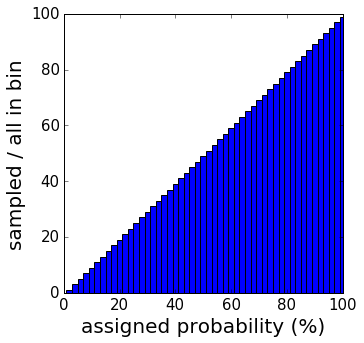

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.arange(1, 100, 2)
ax.bar(x, x, 2)
ax.tick_params(labelsize=15)
ax.set_xlabel('assigned probability (%)', size=20)
ax.set_ylabel('sampled / all in bin', size=20)
ax.set_xlim(0,100)